# Exploratory Analysis of Loan Dataset from Prosper 

## Preliminary Wrangling

Analysis of Prosper's loan dataset, a personal loan company that provides a peer-to-peer lending marketplace. 

The dataset contains features on the loan applications, which are used by Prosper to render ratings on people that request a loan. A list of the attributes and their description can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1CC0PIpSdnPfxHKPzGcdtetAHGZBHJrxTfZBJ5cdZtvc/edit?usp=sharing).

Our analyis will majorly depend upon the question : **How some features present in the dataset may influence the rating given by Prosper to borrowers with no prior loans?**

In [1]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
full_loans = pd.read_csv('prosperLoanData.csv')
loans = full_loans.copy()

In [3]:
# select and drop the listings that have 'ProsperRating'
# select the listings of borrowers with no prior PROSPER loans
loans['ListingCreationDate'] = pd.to_datetime(loans['ListingCreationDate'])

l1 = loans[loans['ListingCreationDate'] < '2009-07-01'].index.tolist()
l2 = loans[loans['ScorexChangeAtTimeOfListing'].notna()].index.tolist()
l3 = loans[loans['TotalProsperLoans'].notna()].index.tolist()

loans.drop(labels=l1+l2+l3, inplace=True)
loans = loans.reset_index(drop=True)

In [4]:
# create a new column 'CreditScoreRange'
loans['CreditScore'] = loans[['CreditScoreRangeLower', 'CreditScoreRangeUpper']].mean(axis=1)


# adjust by 0.5 as this doesn't really make a difference to the data since it is a range
loans['CreditScore'] += 0.5
loans['CreditScore'] = loans['CreditScore'].astype(int)

# select and reorder the attributes that will be analyzed
columns = ['ProsperRating (Alpha)', 'ProsperScore', 'CreditScore', 'Occupation', 'EmploymentStatus', 
           'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 
           'DebtToIncomeRatio', 'TotalInquiries', 'CurrentDelinquencies', 'BankcardUtilization', 'TradesNeverDelinquent (percentage)']

loans = loans[columns]

loans.rename(columns={'ProsperRating (Alpha)': 'ProsperRating', 'TradesNeverDelinquent (percentage)': 'TradesNeverDelinquentRatio'},
             inplace=True)

#### Change datatypes

In [5]:
categories = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
categories = pd.api.types.CategoricalDtype(categories, True)
loans.ProsperRating = loans.ProsperRating.astype(categories)

categories = ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
categories = pd.api.types.CategoricalDtype(categories, ordered=True)
loans.loc[:, 'IncomeRange'] = loans.loc[:, 'IncomeRange'].astype(categories)

categories = loans.EmploymentStatus.unique()
categories = pd.api.types.CategoricalDtype(categories)
loans.loc[:, 'EmploymentStatus'] = loans.loc[:, 'EmploymentStatus'].astype(categories)

In [6]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65056 entries, 0 to 65055
Data columns (total 15 columns):
ProsperRating                 65056 non-null category
ProsperScore                  65056 non-null float64
CreditScore                   65056 non-null int64
Occupation                    63749 non-null object
EmploymentStatus              65056 non-null category
EmploymentStatusDuration      65041 non-null float64
IsBorrowerHomeowner           65056 non-null bool
IncomeRange                   65056 non-null category
IncomeVerifiable              65056 non-null bool
StatedMonthlyIncome           65056 non-null float64
DebtToIncomeRatio             59833 non-null float64
TotalInquiries                65056 non-null float64
CurrentDelinquencies          65056 non-null float64
BankcardUtilization           65056 non-null float64
TradesNeverDelinquentRatio    65056 non-null float64
dtypes: bool(2), category(3), float64(8), int64(1), object(1)
memory usage: 5.3+ MB


### What is the structure of your dataset?

The selected portion of the Prosper Loans Dataset contains 65056 loans listings with 15 variables.

**Rating and Scores** These features describe the score (or rating) received by the borrower and they directly affect the ability of the Borrower to borrow money. They are ProsperRating, ProsperScore and CreditScore.

**Personal Information** These features are personal information provided by the borrower and if and how they affect affect ProsperRating is unclear. They are Occupation, EmploymentStatus, EmploymentStatusDuration, IsBorrowerHomeowner, IncomeRange, IncomeVerifiable and StatedMonthlyIncome.

**Credit Information** These features were probably provided by an authorized credit reporting agency and if and how they affect ProsperRating is also unclear. They are TotalInquiries, CurrentDelinquencies, TradesNeverDelinquentRatio, and BankcardUtilization.

## Univariate Exploration

In [7]:
base_c1 = sb.color_palette('muted', 9)[0]
base_c2 = sb.color_palette('muted', 9)[1]

## Rating and Scores

#### ProsperRating

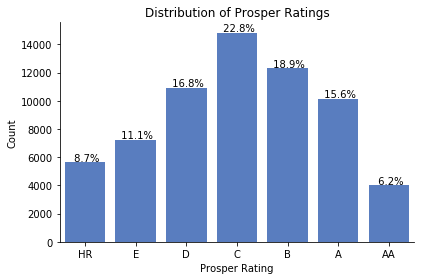

In [8]:
# check the distribution of ProsperRatings
sb.countplot(x=loans['ProsperRating'], color=base_c1)

locs, labels = plt.xticks()

counts = loans.groupby('ProsperRating').size()
total = loans.shape[0]
ticks, labels = plt.xticks()

for tick, label in zip(ticks, labels):
    count = counts.loc[label.get_text()]
    plt.text(x=tick, y=count+100, s=f'{(100*count/total): .1f}%', ha='center') 
plt.title('Distribution of Prosper Ratings')
plt.xlabel('Prosper Rating')
plt.ylabel('Count')
sb.despine(top=True)
plt.tight_layout();

This is the distribution of `ProsperRating`. From this plot, we learn that Prosper rating system is well distributed, with more borrowers falling on middle ratings than on the extremes. Also, we can see that this distribution is slightly left skewed - what is endorsed by the percentage values of each count, which means that Prosper's rating slightly leans towards good ratings.

#### ProsperScore

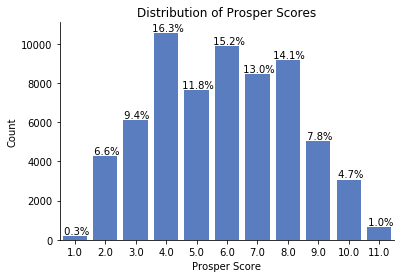

In [9]:
# check the distribution of ProsperScore

sb.countplot(x=loans['ProsperScore'], color=base_c1)

locs, labels = plt.xticks()

counts = loans.groupby('ProsperScore').size()
total = loans.shape[0]
ticks, labels = plt.xticks()

for tick, i in zip(ticks, range(1,12)):
    count = counts[i]
    plt.text(x=tick, y=count+100, s=f'{(100*count/total): .1f}%', ha='center') 

plt.title('Distribution of Prosper Scores')
plt.xlabel('Prosper Score')
plt.ylabel('Count')
sb.despine(top=True)

The shape of `ProsperScore`'s distribution is quite symmetric and resembles the distribution of `ProsperRating`. Just by observing the two distributions, and knowing that `ProsperRating` is built considering `ProsperScore`, we can expected that the values have a strong positive correlation. However, we cannot possibly know how `ProsperRating` is distributed considering `ProsperScore` just by looking at the two distributions. We need to dive further in the relationship of these two variables. Also, by checking the counts of the scores that are less than the middle score of 6.0, we see that they are less than the counts of the borrowers who fall above the middle score, which is the opposite of `ProsperRating`.

#### CreditScore

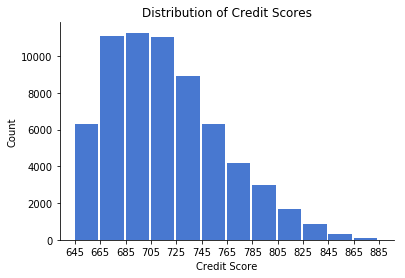

In [10]:
bins = np.arange(loans.CreditScore.min()-5, loans.CreditScore.max()+5, 20)
plt.hist(loans.CreditScore, bins=bins, width=18.5, color=base_c1)
plt.xticks(bins)
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Count')
sb.despine(top=True);

As though `CreditScore` directly influences `ProsperRating`, the shape of this distribution is completely different from the ones we have seen before. It is curious how `CreditScoreRange` has a different distribution of the other two scores.

## Personal Information

#### Occupation

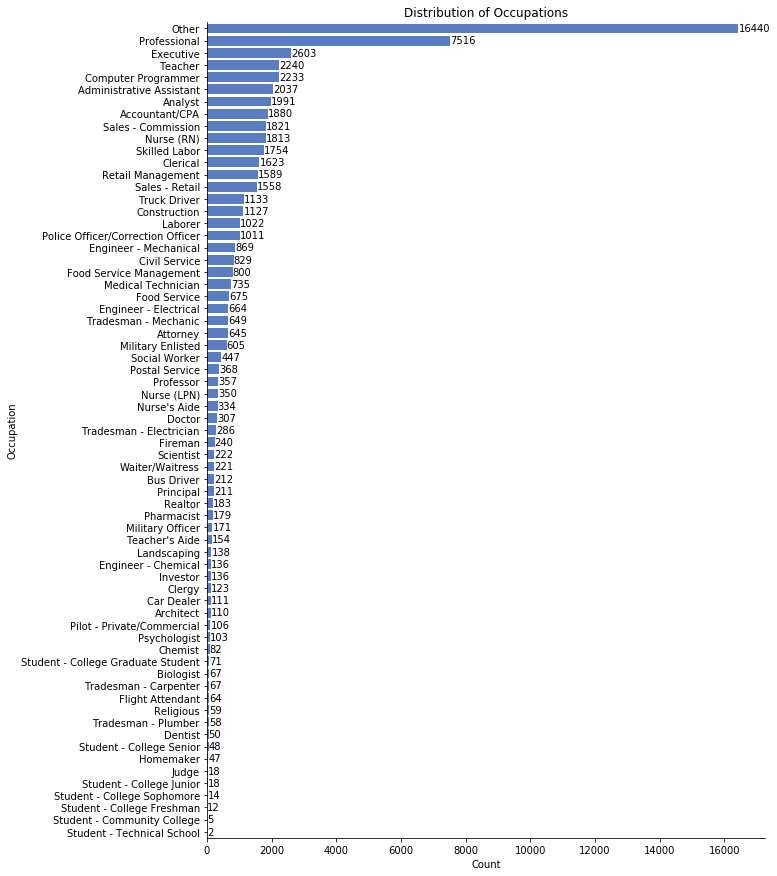

In [11]:
plt.figure(figsize=(10,15))
sb.countplot(data=loans, y='Occupation', order=loans.Occupation.value_counts().index, color=base_c1)

ticks, labels = plt.yticks()

for tick, value in zip(ticks, loans.Occupation.value_counts().values):
    plt.text(y=tick, x=value, s=f'{value}', va='center', )

plt.title('Distribution of Occupations')
plt.xlabel('Count')
sb.despine(top=True);

This data is too granular, with 67 types of occupation that don't seem to admit grouping. In addition, the main occupations observed above do not even give us an idea of what the actual occupation is. 'Other' and 'Professional' are simply not an occupation. Besides, this would hardly give us any idea of its influence on ProsperRating, as `Occupation` is highly related to income. Therefore, I don't think `Occupation` will provide us with any information to support the analysis of `ProsperRating`, so I will drop the analysis of this feature.

#### EmploymentStatus and EmploymentStatusDuration

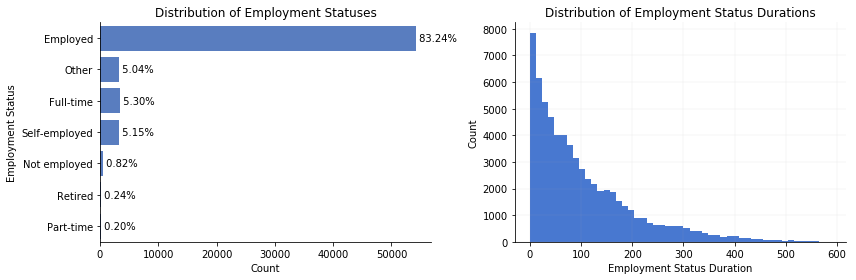

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

# ax1
sb.countplot(data=loans, y='EmploymentStatus', color=base_c1, ax=ax1)
total = loans.shape[0]
for loc, value in zip(ax1.get_yticks(), loans.groupby('EmploymentStatus').size()):
    ax1.text(x=value, y=loc, s=f'{100*value/total: .2f}%', va='center')

ax1.set_title('Distribution of Employment Statuses')    
ax1.set_ylabel('Employment Status')
ax1.set_xlabel('Count')

# ax2
bins= np.arange(0, 600, 12)
plt.hist(loans.EmploymentStatusDuration, bins=bins, color=base_c1)
ax2.set_xlabel('EmploymentStatusDuration')
ax2.set_ylabel('count')
ax2.grid(lw=0.1)
ax2.set_title('Distribution of Employment Status Durations')
ax2.set_xlabel('Employment Status Duration')
ax2.set_ylabel('Count')

# axs
sb.despine(top=True)
plt.tight_layout();

In [13]:
loans.EmploymentStatusDuration.describe()

count    65041.000000
mean       102.957873
std         98.700583
min          0.000000
25%         28.000000
50%         73.000000
75%        149.000000
max        755.000000
Name: EmploymentStatusDuration, dtype: float64

The lack of data on borrowers other than the 'Employed' category and the innacuracy of the data of the other two biggest categories, 'Other' and 'Full Time', may make this a tough feature of which to make sense against ProsperRating. In addition to this, the variable `EmploymentStatus` might be too closely related to the income information of the borrower, and I just find easier to believe that the income information plays a bigger role in `ProsperRating`.

With regard to the distribution of `EmploymentStatusDuration`, we can see a left skewed distribution, highly uneven, with half of the borrowers having spent less than approx. 6 years employed.

#### IsBorrowerHomeowner

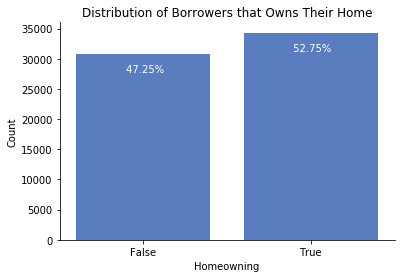

In [14]:
sb.countplot(data=loans, x='IsBorrowerHomeowner', color=base_c1)

total = loans.shape[0]
locs, labels = plt.xticks()

for loc, value in zip(locs, [30737, 34319]):
    plt.text(x=loc, y=value-3000, s=f'{100*value/total: .2f}%', ha='center', color='w')
    
plt.title('Distribution of Borrowers that Owns Their Home')

plt.xlabel('Homeowning')
plt.ylabel('Count')

sb.despine(top=True);

We can see that this variable is almost evenly distributed, with a higher number of borrowers that own their homes. Considering that the homeownership rate in the US was 64.5% in 2014 <a href="#references">[2]</a>, I can say that the non-homeowners represent a share higher than I initially expected of borrowers in Prosper platform.

#### IncomeRange and  StatedMonthlyIncome

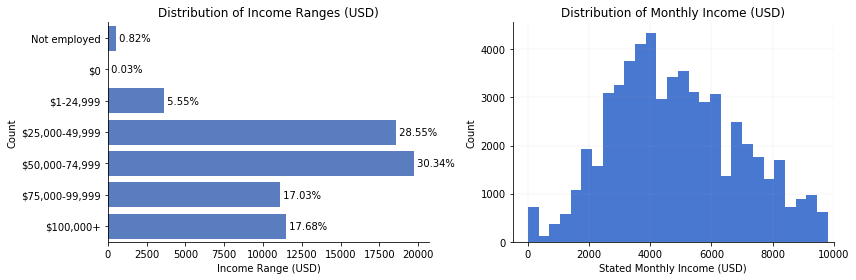

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

# ax1
sb.countplot(data=loans, y='IncomeRange', color=base_c1, ax=ax1)
total = loans.shape[0]
for loc, value in zip(ax1.get_yticks(), loans.groupby('IncomeRange').size()):
    ax1.text(x=value, y=loc, s=f'{100*value/total: .2f}%', va='center')

ax1.set_title('Distribution of Income Ranges (USD)')
ax1.set_xlabel('Income Range (USD)')
ax1.set_ylabel('Count')


# ax2
bins = np.arange(0, 10000, 350)
ax2.hist(loans.StatedMonthlyIncome, bins=bins, color=base_c1);
ax2.set_xlim(-500, 10000)
ax2.set_xlabel('StatedMonthlyIncome')
ax2.set_ylabel('count')
ax2.grid(lw=0.1)

ax2.set_title('Distribution of Monthly Income (USD)')
ax2.set_xlabel('Stated Monthly Income (USD)')
ax2.set_ylabel('Count')

# axs
sb.despine(top=True)
plt.tight_layout();

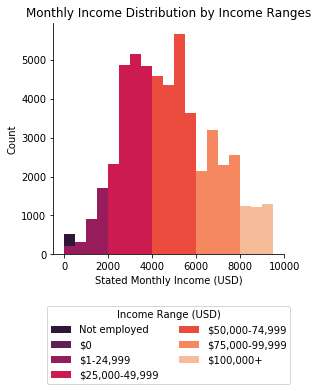

In [16]:
bins = np.arange(0, 10000, 500)
g = sb.FacetGrid(data=loans, hue='IncomeRange', palette='rocket', height=4)
g.map(plt.hist, 'StatedMonthlyIncome', bins=bins)
plt.xlim(-500, 10000)
plt.title('Monthly Income Distribution by Income Ranges')
plt.legend(title = 'Income Range (USD)', 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=2)

plt.ylabel('Count')
plt.xlabel('Stated Monthly Income (USD)');

Apparently, `IncomeRange` and `StatedMontlyIncome` are two different ways of visualizing the same data, what is corroborated by the bivariate plot above. One of them is categorized in ranges and the other one is quantitative continuous data. Considering this, it makes no sense to visualize them separately. In my opinion, it is preferable to analyze the `StatedMonthlyIncome` rather than the `IncomeRange`, since `StatedMontlyIncome` is a quantitative variable.

From the above plots, we can see that the majority of borrowers (roughly 60%) fall within an income range between USD 25,000 and 74,999, and almost the totality of the borrowers have an income beyond USD 25,000, what may mean that it is hard for borrowers with low income to apply for a loan. 

We can see that `StatedMonthlyIncome` has a slightly right skewed distribution, with the median equal to 5000, which means that there is a high probability of finding borrowers with income close to that value.

To me, this must be one of the main influencers of `ProsperRating`. Before analyzing how it affects `ProsperRating`, I should analyze how it affects other personal data.

#### IncomeVerifiable

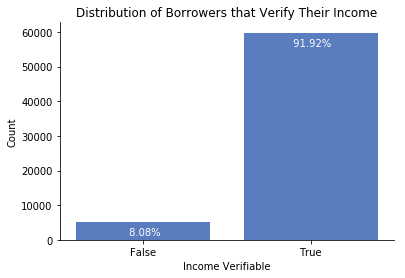

In [17]:
sb.countplot(loans.IncomeVerifiable, color=base_c1)

total = loans.shape[0]
locs, labels = plt.xticks()

for loc, value in zip(locs, [5255, 59801]):
    plt.text(x=loc, y=value-4000, s=f'{100*value/total: .2f}%', ha='center', color='w')

plt.title('Distribution of Borrowers that Verify Their Income')

plt.xlabel('Income Verifiable')
plt.ylabel('Count')

sb.despine(top=True);

Since the majority of the borrowers (91.92%) verifies its income, it's possible that most borrowers that don't verify their income are not able to apply for a listing. 

It should be interesting to see if and how this relates to `StatedMonthlyIncome`.

### Credit Information

This data is related to bank provided information. Most of the variables of the financial data I analyzed had a very uneven distribution. They happened to have a huge amount of values in either one of the extreme of the x-axis, what would render histograms that couldn't be read. In these cases, I decided to transform the y-scale to logarithmic scale. Although not perfect, we are now able to better visualize the distribution of the values (taking into account the log scale).

#### DebtToIncomeRatio

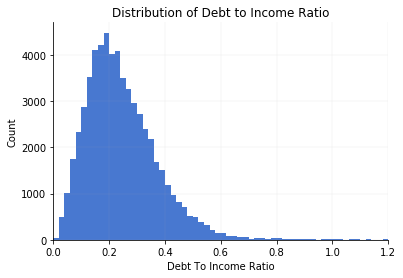

In [18]:
bins = np.arange(0,2, 0.02)
plt.hist(loans.DebtToIncomeRatio, bins=bins, color=base_c1)
plt.xlim(0,1.2)
plt.grid(lw=0.1)
plt.title('Distribution of Debt to Income Ratio')
sb.despine(top=True)

plt.xlabel('Debt To Income Ratio')
plt.ylabel('Count');

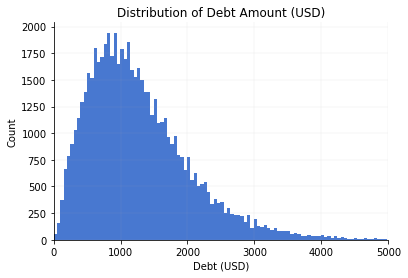

In [19]:
loans['ExpectedMonthlyDebt'] = loans['DebtToIncomeRatio'] * loans['StatedMonthlyIncome']

# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 5000]
plt.hist(data=sl, x='ExpectedMonthlyDebt', bins=100, color=base_c1);
plt.xlim(0, 5000)
plt.grid(lw=0.1)

plt.title('Distribution of Debt Amount (USD)')
plt.xlabel('Debt (USD)')
plt.ylabel('Count')

sb.despine(top=True);

We can see a slightly right skewed distribution of `DebtToIncomeRatio` with a median of 0.22, which means we have a high probability of finding people with debt representing roughly 22% of their income.

Since this variable is, in theory, a ratio between the debt and the income of the borrower, I created the variable `ExpectedMonthlyDebt` to express the debt by month of the borrower. Supposedly, the new variable is relatively independent from `StatedMonthlyIncome`, which is something I will have to verify.

#### TotalInquiries

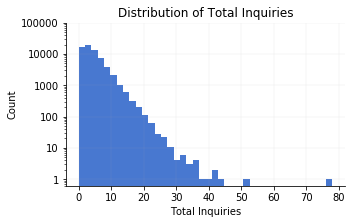

In [20]:
plt.figure(figsize=(5, 3))
plt.hist(loans['TotalInquiries'], bins=40, color=base_c1)
plt.yscale('log')
plt.grid(lw=0.1)

t = [1, 10, 100, 1000, 10000, 100000]
plt.yticks(t, t)

plt.title('Distribution of Total Inquiries')
plt.xlabel('Total Inquiries')
plt.ylabel('Count')

sb.despine(top=True);

We learn from this distribution that this data is far uneven, and decrease in an exponential proportion. This means that a lot of borrowers lie in 0, meaning that no bank has ever made inquiries for the majority of the borrowers. This data seems somewhat related to delinquencies, so I will analyze how they compare and then analyze how this affects `ProsperRating`.

#### CurrentDelinquencies

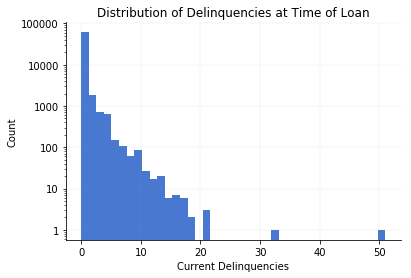

In [21]:
plt.hist(loans['CurrentDelinquencies'], bins=40, color=base_c1)
plt.yscale('log')
plt.title('Distribution of Delinquencies at Time of Loan')
plt.xlabel('Current Delinquencies')
plt.ylabel('Count')
t = [1, 10, 100, 1000, 10000, 100000]
plt.yticks(t, t)
plt.grid(lw=0.1)
sb.despine(top=True)

This variable relates to the number of delinquencies at the moment the credit information was pulled and the other one is related to how delinquent is the borrower in relation to the credit trades the borrower has ever had (`TradesNeverDelinquentRatio`). About this data, we can say the same as `TotalInquiries`, the data is far uneven, and decrease, or increase, in an exponential proportion.

#### TradesNeverDelinquentRatio

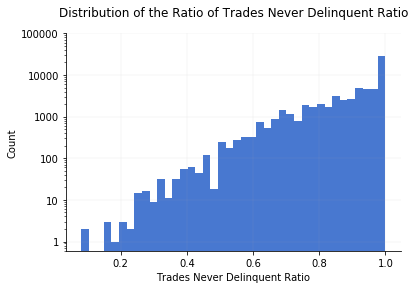

In [22]:
plt.hist(loans['TradesNeverDelinquentRatio'], bins=40, color=base_c1)
plt.yscale('log')
plt.title('Distribution of the Ratio of Trades Never Delinquent Ratio', y=1.05)
plt.xlabel('Trades Never Delinquent Ratio')
plt.ylabel('Count')
plt.grid(lw=0.1)
plt.yticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000])
sb.despine(top=True)

#### BankcardUtilization

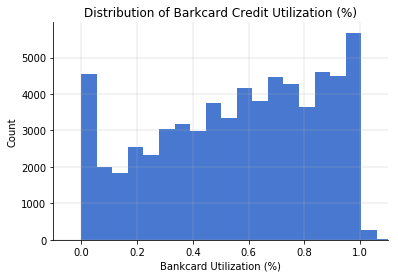

In [23]:
plt.hist(loans.BankcardUtilization, bins=40, color=base_c1)
plt.xlim(-0.1, 1.1)
plt.grid(linewidth=0.3)

plt.title('Distribution of Barkcard Credit Utilization (%)')
plt.xlabel('Bankcard Utilization (%)')
plt.ylabel('Count')
sb.despine(top=True);

This data shows a very left skewed distribution, with spikes in both close to 0.0 and to 1.0. According to the plot, a lot of people fall in the extremes of either using no Bankcard credit or using all of it. This is an interesting finding and it could be interesting to visualize this against the other variables.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

It is interesting how `ProsperRating` has different distribution when compared to `CreditScore`. I was expecting that since `ProsperRating` is built based on `ProsperScore` and `CreditScore`, all of them would have very similar distributions. As to `ProsperScore`, this feature has a distribution that is fairly similar to `ProsperRating`.

I observed that the data for most features is very uneven, what may make the analysis difficult for such features.

I performed the transformation of two variables. Initially, we are provided only with the upper and lower ranges of the credit scores and we can only know that a borrower falls within a range. Calculating the mean of such ranges was not really necessary, but I think that doing so better represents the `CreditScore`. Also, I created the feature `ExpectedMonthlyDebt`, by multiplying `DebtToIncomeRatio` and `StatedMonthlyIncome`, so I could better understand the role of the amount of debt in `ProsperRating`.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
As mentioned above, most of the variables of the financial data I analyzed had a very uneven distribution. They happened to have a huge amount of values in either one of the extreme of the x-axis, what would render histograms that couldn't be read. In these cases, I decided to transform the y-scale to logarithmic scale.

## Bivariate Exploration

I will start by comparing each variable within its group of variables. As I believe the variables within a group to be somehow related, I want to see how they compare to each other before comparing them to variables of other groups.

### ProsperRating vs. Scores

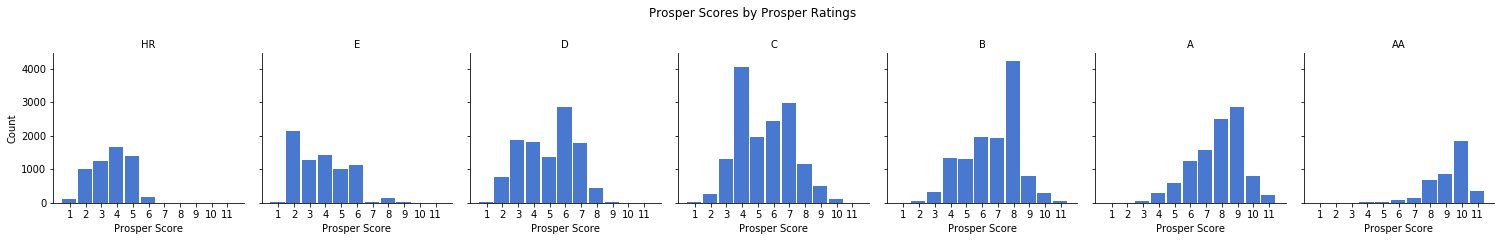

In [24]:
bins = np.arange(0.5, 12)

g = sb.FacetGrid(data=loans, col='ProsperRating')
g.map(plt.hist, 'ProsperScore', bins=bins, width=0.9, color=base_c1)
g.fig.suptitle('Prosper Scores by Prosper Ratings', x=0.5, y=1.1)
g.set_xlabels('Prosper Score')
g.set_ylabels('Count')
g.set_titles('{col_name}')
plt.xticks(np.arange(1,12), np.arange(1,12))
plt.tight_layout();

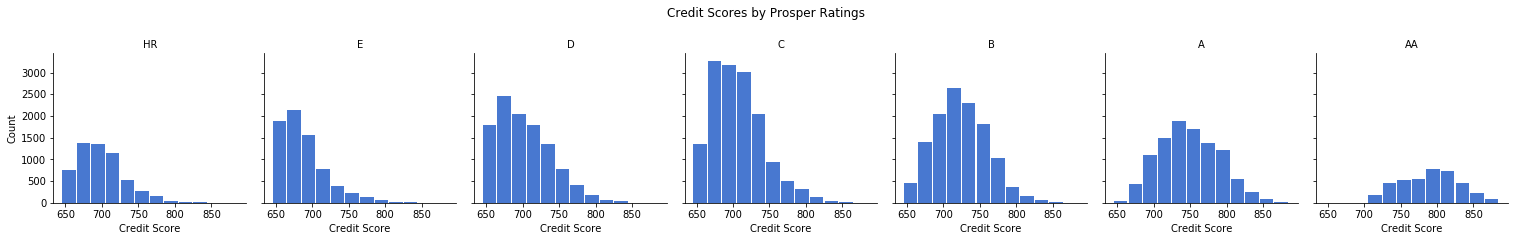

In [25]:
bins = np.arange(loans.CreditScore.min()-4.5, loans.CreditScore.max()+5.5, 20)

g = sb.FacetGrid(data=loans, col='ProsperRating')
g.map(plt.hist, 'CreditScore', bins=bins, width=18.5, color=base_c1)
g.set_xlabels('Credit Score')
g.set_ylabels('Count')
g.set_titles('{col_name}')
g.fig.suptitle('Credit Scores by Prosper Ratings', x=0.5, y=1.1);

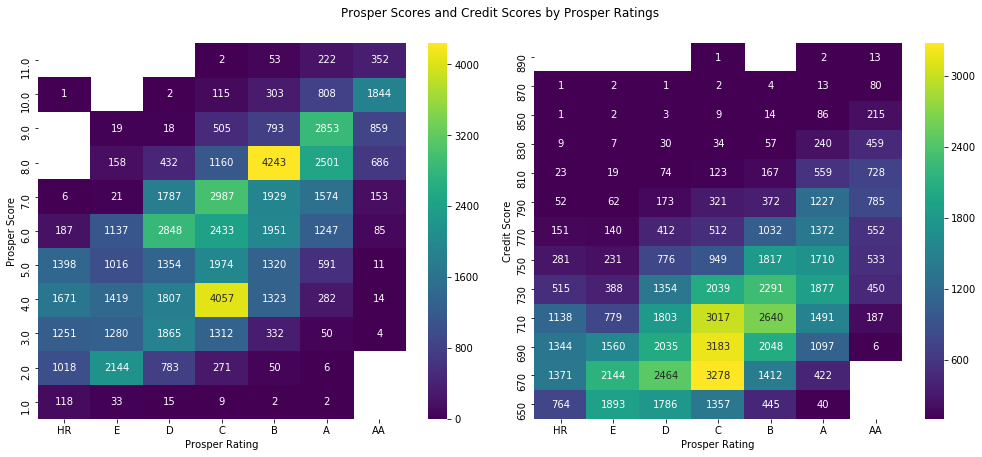

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))

fig.suptitle('Prosper Scores and Credit Scores by Prosper Ratings', x=0.5, y=1.05)

# ax1
counts = loans.groupby(['ProsperScore', 'ProsperRating']).size()
counts = counts.reset_index(name = 'count')
counts = counts.pivot(index = 'ProsperScore', columns = 'ProsperRating', values = 'count')

sb.heatmap(counts, annot=True, fmt='.0f', ax=ax1, cmap='viridis')
ax1.invert_yaxis()

ax1.set_xlabel('Prosper Rating')
ax1.set_ylabel('Prosper Score')

# ax2
counts = loans.groupby(['ProsperRating', 'CreditScore']).size()
counts = counts.reset_index(name = 'count')
counts = counts.pivot(index = 'CreditScore', columns = 'ProsperRating', values = 'count')

sb.heatmap(counts, annot=True, fmt='.0f', ax=ax2, cmap='viridis', vmin=100)

ax2.set_xlabel('Prosper Rating')
ax2.set_ylabel('Credit Score')

ax2.invert_yaxis()
plt.tight_layout();

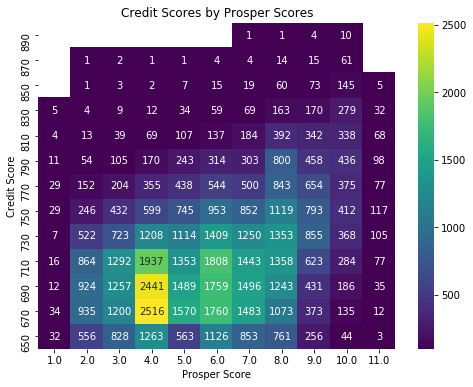

In [27]:
plt.figure(figsize=(8,6))

counts = loans.groupby(['ProsperScore', 'CreditScore']).size()
counts = counts.reset_index(name = 'count')
counts = counts.pivot(index = 'CreditScore', columns = 'ProsperScore', values = 'count')

ax = sb.heatmap(counts, annot=True, fmt='.0f', cmap='viridis', vmin=100)

ax.set_ylabel('Credit Score')
ax.set_xlabel('Prosper Score')

ax.set_title('Credit Scores by Prosper Scores', y=1.1)

ax.invert_yaxis();

Here we can visualize the distribution of `ProsperScore` and `CreditScore` grouped by `ProsperRating`. 

In both distributions, we can see shifting of the distribution along the x-axis as `ProsperRaiting` rises. Although this behavior was expected, as we know that the `ProsperScore` and `CreditScore` is highly influential of `ProsperRating`, a lot of values lie on the borders of the main ratings, showing a more broad distribution than I initially expected.

The heatmaps above shows the relationship between the variables and it also shows what was mentioned below. Mainly for `ProsperScore`, there is a wide range of values for each `ProsperRating`.

This may corroborate the supposition that other varibles influence the `ProsperRating`.

We can see that `ProsperScore` and `CreditScore` have a certain correlation. We could expect these variables are scores of the borrowers, sometimes based in related variables. We can see, though, that the relationship between these two variables are not as strong as the correlation observed for these two variables against `ProsperRating`.

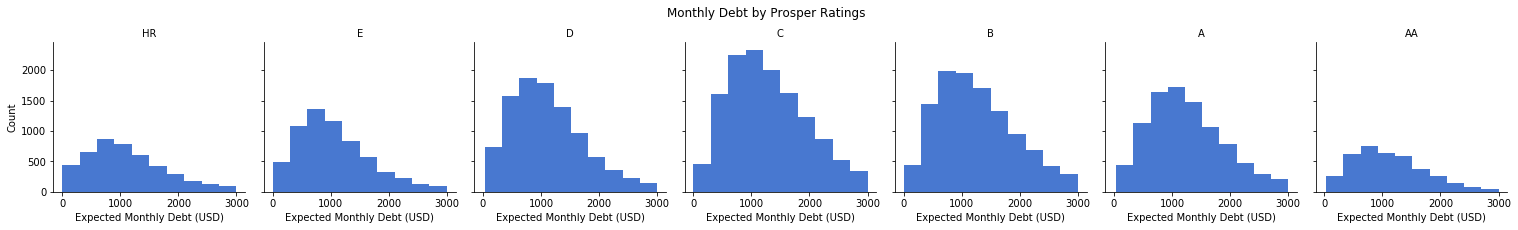

In [31]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] <= 3000]
g = sb.FacetGrid(data=sl, col='ProsperRating')
g.fig.suptitle('Monthly Debt by Prosper Ratings', y=1.05)
g.map(plt.hist, 'ExpectedMonthlyDebt', color=base_c1)
g.set_xlabels('Expected Monthly Debt (USD)')
g.set_ylabels('Count')
g.set_titles('{col_name}');

#### IsBorrowerHomeowner and  IncomeVerifiable

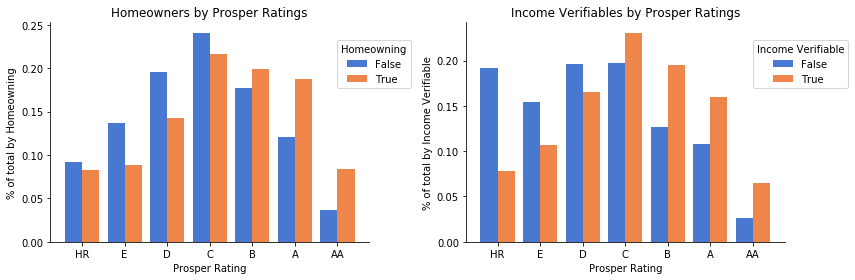

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))


#ax1
counts_false = loans.groupby(['IsBorrowerHomeowner', 'ProsperRating']).size()[0]
total_false = counts_false.sum()

counts_true = loans.groupby(['IsBorrowerHomeowner', 'ProsperRating']).size()[1]
total_true = counts_true.sum()

labels = counts_false.index
y_false = counts_false.values/total_false
y_true = counts_true.values/total_true

locs = np.arange(1, 8)

axs[0].bar(x=locs-0.2, height=y_false, width=0.4, color=sb.color_palette('muted', 9)[0])
axs[0].bar(x=locs+0.2, height=y_true, width=0.4, color=sb.color_palette('muted', 9)[1])

axs[0].set_xticks(locs)
axs[0].set_xticklabels(labels)
axs[0].set_title('Homeowners by Prosper Ratings')
axs[0].set_xlabel('Prosper Rating')
axs[0].set_ylabel('% of total by Homeowning')
axs[0].legend(title='Homeowning', labels=['False', 'True'], loc=(0.9,0.7))
sb.despine(top=True)

#ax2
counts_false = loans.groupby(['IncomeVerifiable', 'ProsperRating']).size()[0]
total_false = counts_false.sum()

counts_true = loans.groupby(['IncomeVerifiable', 'ProsperRating']).size()[1]
total_true = counts_true.sum()

labels = counts_false.index
y_false = counts_false.values/total_false
y_true = counts_true.values/total_true

locs = np.arange(1, 8)

axs[1].bar(x=locs-0.2, height=y_false, width=0.4, color=sb.color_palette('muted', 9)[0])
axs[1].bar(x=locs+0.2, height=y_true, width=0.4, color=sb.color_palette('muted', 9)[1])

axs[1].set_xticks(locs)
axs[1].set_xticklabels(labels)
sb.despine(top=True)
axs[1].set_title('Income Verifiables by Prosper Ratings')
axs[1].set_xlabel('Prosper Rating')
axs[1].set_ylabel('% of total by Income Verifiable')
axs[1].legend(title='Income Verifiable', labels=['False', 'True'], loc=(0.9,0.7))
plt.tight_layout();

By visualizing these variables in an absolute scale it does not become clear that `IsBorrowerHomeOwner` have a relationship with the Scores. However, with the y-scale put in proportion, the relationship between owning your home and getting high scores becomes clearer. 

Given the distribution of the variable `IsBorrowerHomeOwner`, which is almost evenly distributed in this dataset, and given the difference between its distribution in relation to `ProsperRating`, we may have found a relationship between owning a house and receiving a high `ProsperRating`. We might want to consider plotting other variables afterwards to see if the relationship is sustained or it is a consequence of other relationships between `IsBorrowerHomeOwner` and other variables.

Here we can see that the distribution of `BankcardUtilization` gradually changes its shape for each category of `ProsperRating`. For low `ProsperRating` the distribution is very left skewed and as the `ProsperRating` gets higher, the less borrowers use the totality of its bankcard credit. As a consequence, we can see the median falling gradually as `ProsperRating` rises, what indicates that there is a negative relationship between the two variables.

### Personal Information vs. Personal Information

As I analyzed all the variables above against `ProsperRating`, I should question if the other variables have any relationship with each other. My guess is that the Personal Information is somehow related and also the Credit Information. It is also possible that the Personal Information, mainly the Income data, has some kind of relationship with the Credit Information, I will check that.

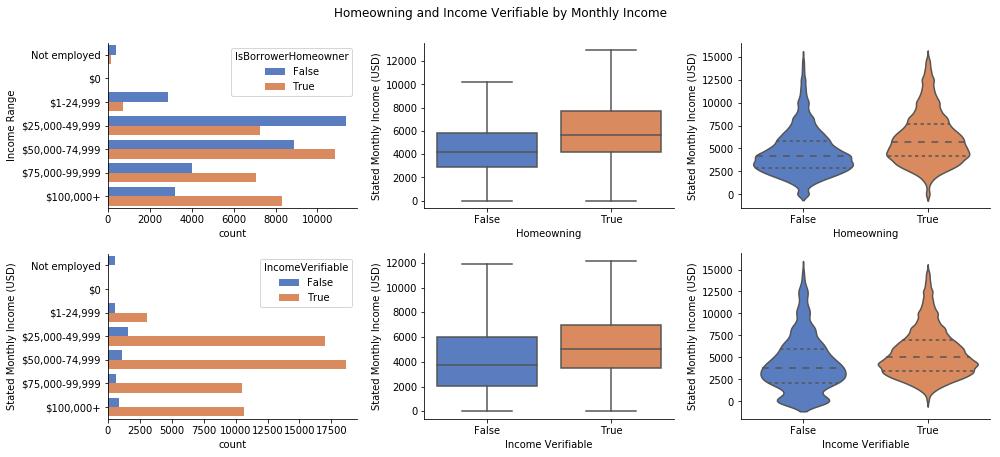

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

fig.suptitle('Homeowning and Income Verifiable by Monthly Income', y=1.05)

axs = axs.ravel()
(ax1, ax2, ax3, ax4, ax5, ax6) = axs

# ax1
sb.countplot(data=loans, y='IncomeRange', hue='IsBorrowerHomeowner', palette='muted', ax=ax1)
total = loans.shape[0]
locs, labels = plt.yticks()
ax1.set_ylabel('Income Range')


# ax2
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 15000]
sb.boxplot(data=sl, x='IsBorrowerHomeowner', y='StatedMonthlyIncome', showfliers=False, ax=ax2, palette='muted')
ax2.set_xlabel('Homeowning')
ax2.set_ylabel('Stated Monthly Income (USD)')

# ax3
sb.violinplot(data=sl, x='IsBorrowerHomeowner', y='StatedMonthlyIncome', showfliers=False, inner='quartile', ax=ax3, palette='muted')
ax3.set_xlabel('Homeowning')
ax3.set_ylabel('Stated Monthly Income (USD)')

# ax4
sb.countplot(data=loans, y='IncomeRange', hue='IncomeVerifiable', palette='muted', ax=ax4)
total = loans.shape[0]
locs, labels = plt.yticks()
ax4.set_ylabel('Income Range')
ax4.set_ylabel('Stated Monthly Income (USD)')

# ax5
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 15000]
sb.boxplot(data=sl, x='IncomeVerifiable', y='StatedMonthlyIncome', showfliers=False, ax=ax5, palette='muted')
ax5.set_xlabel('Income Verifiable')
ax5.set_ylabel('Stated Monthly Income (USD)')

# ax6
sb.violinplot(data=sl, x='IncomeVerifiable', y='StatedMonthlyIncome', showfliers=False, inner='quartile', ax=ax6, palette='muted')
ax6.set_xlabel('Income Verifiable')
ax6.set_ylabel('Stated Monthly Income (USD)')

sb.despine(top=True)
plt.tight_layout();

As mentioned above, `IncomeRange` and `StatedMontlyIncome` are two ways of visualizing the same data, so I won't be analyzing `IncomeRange` as a separate variable. I kept it on this plot just so we could better visualize how `IsBorrowerHomeowner` relate to income categories.

The above plots show that there is a strong relationship between owning a home and the income, what is sort of expected.

Now, since these variables seem somewhat related, I will analyze them in the multivariate exploration below. In this case, I will have to find out if, for borrowers within the same monthly income, somehow having a home changes their `ProsperRating`.

Though the amount of data available on borrowers that don't verify their income is far less than the borrowers that verify their income, we can see that the ones that verify the income generally have a higher income than the ones that do not verify. I suppose that Prosper is less inclined to let borrowers state to have a high monthly income without verifying it.

### Personal Information vs. Credit Information

As `StatedMonthlyIncome` is the most influential variable within the Personal Information variables, I will check its relationship with Credit Information variables.

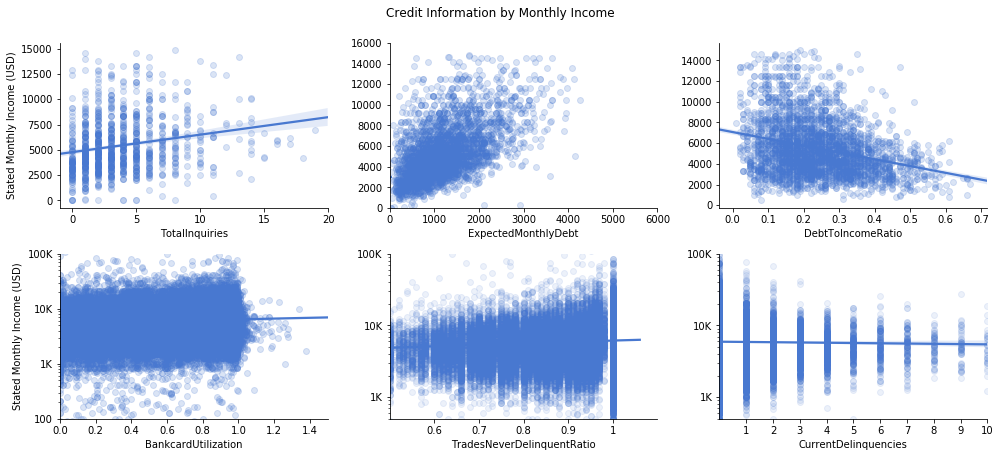

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

fig.suptitle('Credit Information by Monthly Income', y=1.05)

axs = axs.ravel()
(ax7, ax8, ax9, ax10, ax12, ax13) = axs

# ax7
# remove the outliers
sl = loans[(loans['StatedMonthlyIncome'] < 15000)&(loans['TotalInquiries'] < 20)].sample(1000)
sb.regplot(data=sl, y='StatedMonthlyIncome', x='TotalInquiries', color=base_c1,scatter_kws={'alpha':0.2}, ax=ax7)
ax8.set_xlim(0,30)
ax8.set_ylim(0,16000)
ax7.set_ylabel('Stated Monthly Income (USD)')

# ax8
# remove the outliers
sl = loans[(loans['ExpectedMonthlyDebt'] < 100000)&(loans['StatedMonthlyIncome'] < 15000)].sample(3000)
sb.regplot(data=sl, x='ExpectedMonthlyDebt', y='StatedMonthlyIncome', color=base_c1, scatter_kws={'alpha':0.2}, ax=ax8)
ax8.set_xlim(0,6000)
ax8.set_ylim(0,16000)
ax8.set_ylabel('')

# ax9
# remove the outliers
sl = loans[(loans['DebtToIncomeRatio'] < 0.7)&(loans['StatedMonthlyIncome'] < 15000)].sample(3000)
sb.regplot(data=sl, y='StatedMonthlyIncome', x='DebtToIncomeRatio', scatter_kws={'alpha': 0.2}, color=base_c1, ax=ax9)
ax9.set_ylabel('')

# ax10
sb.regplot(y='StatedMonthlyIncome', x='BankcardUtilization', data=loans, scatter_kws={'alpha': 0.2}, ax=ax10, color=base_c1)
ax10.set_yscale('log')
ax10.set_ylim(100,100000)
ax10.set_xlim(0,1.5)
ax10.set_ylabel('Stated Monthly Income (USD)')
t = [100, 1000, 10000, 100000]
l = ['100', '1K', '10K', '100K']
ax10.set_yticks(t)
ax10.set_yticklabels(l)

#ax12
sb.regplot(y='StatedMonthlyIncome', x='TradesNeverDelinquentRatio', data=loans, scatter_kws={'alpha':0.1}, ax=ax12, color=base_c1)
ax12.set_yscale('log')
# ax12.set_xscale('log')
ax12.set_ylim(500,100000)
ax12.set_ylabel('')
t = [1000, 10000, 100000]
l = ['1K', '10K', '100K']
ax12.set_yticks(t)
ax12.set_yticklabels(l)
t = [0.6, 0.7, 0.8, 0.9, 1]
ax12.set_xticks(t)
ax12.set_xticklabels(t)
ax12.set_xlim(0.5, 1.1)

#ax13
sb.regplot(y='StatedMonthlyIncome', x='CurrentDelinquencies', data=loans, scatter_kws={'alpha':0.1}, ax=ax13, color=base_c1)
ax13.set_yscale('log')
ax13.set_ylim(500,100000)
ax13.set_xlim(0,10)
ax13.set_ylabel('')
t = [1000, 10000, 100000]
l = ['1K', '10K', '100K']
ax13.set_yticks(t)
ax13.set_yticklabels(l)
t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax13.set_xticks(t)
ax13.set_xticklabels(t)


# axs
sb.despine(top=True)
plt.tight_layout();

A relationship can also be observed between `StatedMonthlyIncome` and `ExpectedMonthlyDebt`. As `ExpectedMonthlyDebt` has a less evident relationship with `ProsperRating`, I will try to understand what is the role played by `ExpectedMonthlyDebt` in the rating system.

Again, since these variables seem somewhat related, I will analyze them in the multivariate exploration below. Here I will have to find out if, for borrowers within the same monthly income, somehow verifying your income changes their `ProsperRating`.

In order to plot the relationship between `StatedMonthlyIncome` and credit information, I had to get rid of the outliers by limiting the x and y axes. Here I found no relationship between `StatedMonthlyIncome` and these variables, which means that they have no influence on each other and can be independently analyzed against the `ProsperRating`.

### Credit Information vs. Credit Information

What if the credit information features influences in each other? I should plot them togheter to evaluate. For this, I will pick specific variables, `AmountDelinquent`, `DebtToIncomeRatio`,   and `BankcardUtilization`.

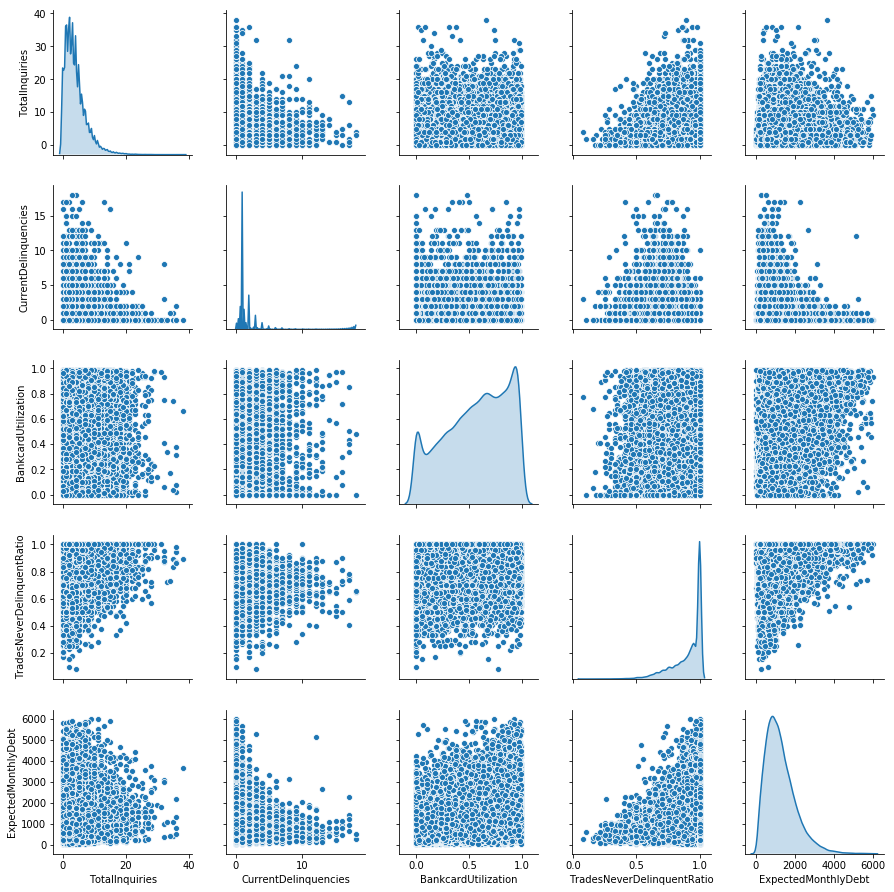

In [39]:
# remove the outliers

fig.suptitle('Credit Information by Credit Information', y=1.05)

sl = loans[(loans['TradesNeverDelinquentRatio'] <= 1)&(loans['DebtToIncomeRatio'] > 0)&(loans['ExpectedMonthlyDebt'] < 6000)&(loans['CurrentDelinquencies'] < 20)&(loans['TotalInquiries'] < 40)&(loans['BankcardUtilization'] < 1)]
sb.pairplot(sl[['TotalInquiries', 'CurrentDelinquencies', 'BankcardUtilization', 'TradesNeverDelinquentRatio', 'ExpectedMonthlyDebt']], diag_kind='kde');

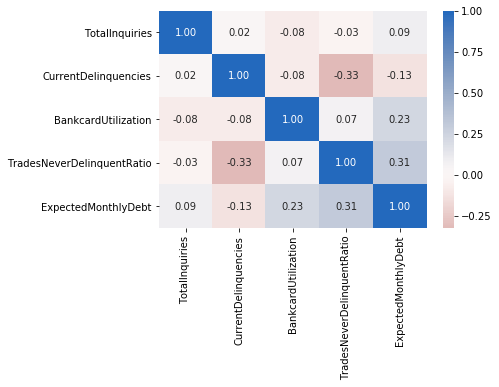

In [40]:
# remove the outliers
sl = loans[(loans['TradesNeverDelinquentRatio'] <= 1)&(loans['DebtToIncomeRatio'] > 0)&(loans['ExpectedMonthlyDebt'] < 6000)&(loans['CurrentDelinquencies'] < 20)&(loans['TotalInquiries'] < 40)&(loans['BankcardUtilization'] < 1)]
sl = sl[['TotalInquiries', 'CurrentDelinquencies', 'BankcardUtilization', 'TradesNeverDelinquentRatio', 'ExpectedMonthlyDebt']]
sb.heatmap(sl.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0);

Apart from the variables that intrinsically have some relationship, which can be grouped into groups (i.e. features related to delinquencies), I did not find any relationship between any of the secondary features, even by eliminating values that would bias the result towards the nonexistance of a relationship.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

I was able to visualize the distribution of all variables against `ProsperScore`, and got some insights from it.

First, about the formation of `ProsperRating` -- in relation to the **Scores**, I was able to find a positive relationship between `ProsperRating` and `ProsperScore` and between `ProsperRating` and `CreditScore`. The relationship with `ProsperScore` was more clear, what may indicate that `ProsperScore` influences more the formation of `ProsperRating` than `CreditScore`.

With this regard, I found something curious about the distribution of `ProsperScore` and `CreditScore` in relation to each category of `ProsperRating`. A lot of values for each `ProsperRating` category lie on the borders of the median Score, showing that the distribution is actually broad and variables other than `ProsperScore` and `CreditScore` influence `ProsperRating`.

With regards to **Personal Information**, I visualized a positive relationship between all variables (i.e. `StatedMonthlyIncome`, `IsBorrowerHomeowner` and `IncomeVerifiable`) and `ProsperRating`. I was also able to visualize a positive relationship between `StatedMonthlyIncome` and the other Personal Information variables (i.e. `IsBorrowerHomeowner`, `IncomeVerifiable` and `ExpectedMonthlyDebt`), so the question that remains is *how much do these variables independently influence `ProsperRating` and how much is because of the influence of `StatedMonthlyIncome`?*

With regards to **Credit Information**, I visualized a negative relationship between credit inquiry information (i.e. `InquiriesLast6Months` and `TotalInquiries`) and `ProsperRating`. It became clear that the less inquiries made on the borrower, the higher the `ProsperRating`. I was also able to identify the ranges of inquiries commonly found for each category. 

I was also able to find a negative relationship between delinquencies information and `ProsperRating`. The lower the number of delinquencies and the amount delinquent, the higher the `ProsperRating`. Having no delinquecies will not necessarily guarantee a high `ProsperRating`, but having no delinquencies will play a much higher role in receiving a high `ProsperRating` than having at least 1 delinquency with low value. We can see that the median gets progressively lower as the ProsperRating rises. This means that it might affect the ProsperRating.

As for the relationship between `BankcardUtilization` and `ProsperRating`, I could see that there is a negative relationship between the two variables, `ProsperRating` gets higher the less the borrowers use the totality of their bankcard credit.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

As mentioned above, I observed a positive relationship between `StatedMonthlyIncome` and the other Personal Data variables, since Income information seemed to be the variable that most influenced `ProsperRating`.


## Multivariate Exploration

For this exploration, I will plot together the variables that I found to have some kind of relationship, in order to better understand how these variables influence `ProsperRating`.

#### Formation of `ProsperRating`

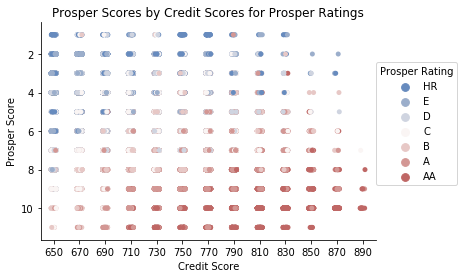

In [41]:
plt.title('Prosper Scores by Credit Scores for Prosper Ratings')

plot = sb.stripplot(y='ProsperScore', x='CreditScore', hue='ProsperRating', palette='vlag', data=loans, jitter=True)
plt.legend(title='Prosper Rating', loc=(1, 0.25))
plot.invert_yaxis()
sb.despine(top=True)
plt.ylabel('Prosper Score')
plt.xlabel('Credit Score');

Although it is hard to visualize, we can at last observe that `ProsperRating` is more influenced by `ProsperScore` than by `CreditScore`, since high `ProsperRating`s are more related to high `ProsperScore`s than to high `CreditScore`s.

#### Influence of `StatedMonthlyIncome`

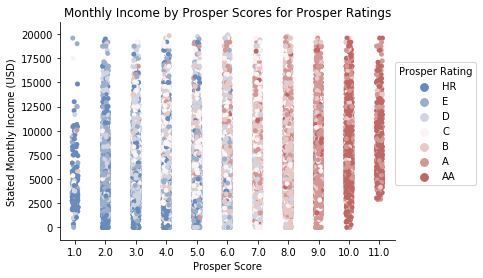

In [42]:
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 20000]

sb.stripplot(x='ProsperScore', y='StatedMonthlyIncome', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Income by Prosper Scores for Prosper Ratings')
plt.ylabel('Stated Monthly Income (USD)')
plt.xlabel('Prosper Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

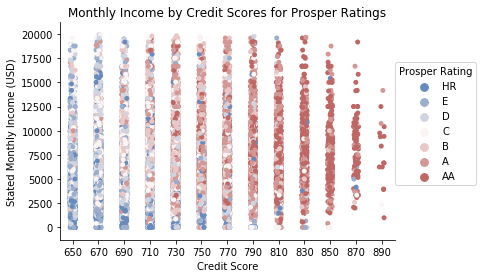

In [43]:
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 20000]

sb.stripplot(x='CreditScore', y='StatedMonthlyIncome', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Income by Credit Scores for Prosper Ratings')
plt.ylabel('Stated Monthly Income (USD)')
plt.xlabel('Credit Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True)

We can see here that `ProsperScore` looks just slightly influenced by `StatedMonthlyIncome`, but not too much -- aside from the extremes (1.0 and 11.0), as we should expect a more impactful change of colors along the y-axis. `CreditScore`, on the other hand, seems more influenced by `StatedMonthlyIncome`, although it is hard to tell by these plots.

#### Influence of `ExpectedMonthlyDebt`

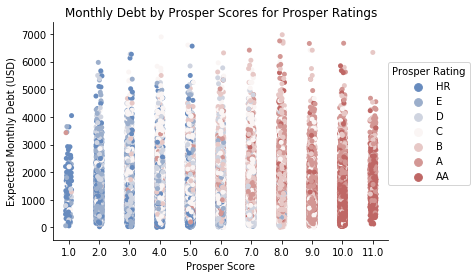

In [44]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 7000]
sb.stripplot(x='ProsperScore', y='ExpectedMonthlyDebt', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Debt by Prosper Scores for Prosper Ratings')
plt.ylabel('Expected Monthly Debt (USD)')
plt.xlabel('Prosper Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

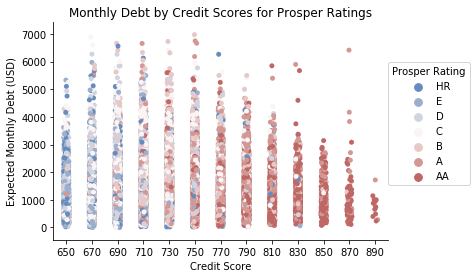

In [45]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 7000]
sb.stripplot(x='CreditScore', y='ExpectedMonthlyDebt', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Debt by Credit Scores for Prosper Ratings')
plt.ylabel('Expected Monthly Debt (USD)')
plt.xlabel('Credit Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

`CreditScore` looks really influenced by the amount of Monthly Debt of a borrower, as we can find a concentration of points with high `CreditScore` ratings more on the bottom right of the plot. The same doesn't happen with `ProsperRating`.

#### Influence of `TotalInquiries`

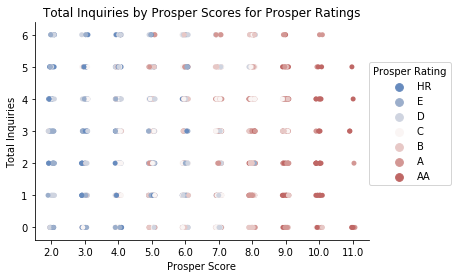

In [46]:
# remove the outliers
sl = loans[loans['TotalInquiries'] < 7].sample(1000)
sb.stripplot(x='ProsperScore', y='TotalInquiries', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Total Inquiries by Prosper Scores for Prosper Ratings')
plt.ylabel('Total Inquiries')
plt.xlabel('Prosper Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

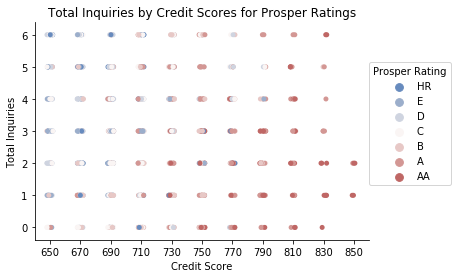

In [47]:
# remove the outliers
sl = loans[loans['TotalInquiries'] < 7].sample(1000)
sb.stripplot(x='CreditScore', y='TotalInquiries', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Total Inquiries by Credit Scores for Prosper Ratings')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Total Inquiries')
plt.xlabel('Credit Score')
sb.despine(top=True);

I can't really find any hints of the influence of TotalInquiries in any of the Scores.

#### Influence of `TradesNeverDelinquent (percentage)`

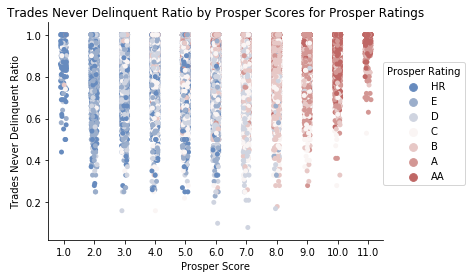

In [48]:
sb.stripplot(x='ProsperScore', y='TradesNeverDelinquentRatio', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Trades Never Delinquent Ratio by Prosper Scores for Prosper Ratings')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Trades Never Delinquent Ratio')
plt.xlabel('Prosper Score')
sb.despine(top=True);

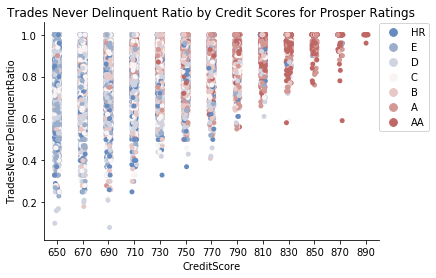

In [50]:
sb.stripplot(x='CreditScore', y='TradesNeverDelinquentRatio', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Trades Never Delinquent Ratio by Credit Scores for Prosper Ratings')
plt.legend(loc=(1, 0.5))
sb.despine(top=True);

One thing to be considered is the absense of points in one part of the plot. We can see that `CreditScore` has no points does not have points evenly distributed, as it happens with `ProsperScore`, what indicates that this variable seems to influence `CreditScore` more than it influences `ProsperScore`. 

#### Influence of `BankcardUtilization`

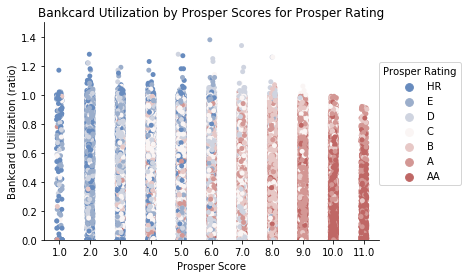

In [51]:
sb.stripplot(x='ProsperScore', y='BankcardUtilization', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Bankcard Utilization by Prosper Scores for Prosper Rating')
plt.ylim(0,1.5)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Bankcard Utilization (ratio)')
plt.xlabel('Prosper Score')
sb.despine(top=True);

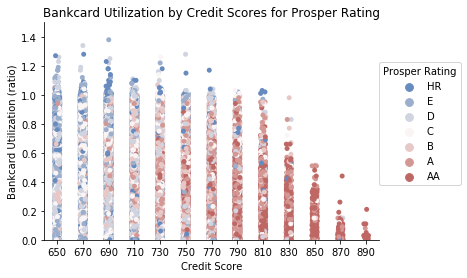

In [52]:
sb.stripplot(x='CreditScore', y='BankcardUtilization', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Bankcard Utilization by Credit Scores for Prosper Rating')
plt.ylim(0,1.5)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Bankcard Utilization (ratio)')
plt.xlabel('Credit Score')
sb.despine(top=True);

Although not very clear, for `CreditScore`, we can see that the bottom of the plot gets consistently darker as `CreditScore` rises, what could mean that `CreditScore` is also more influenced by `BankcardUtilization` than `ProsperScore` is. Maybe we should plot a boxplot to visualize this.

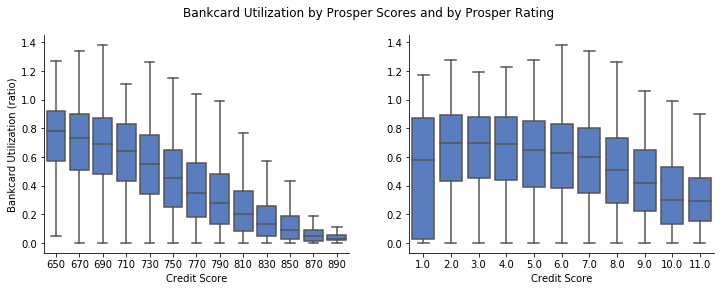

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

fig.suptitle('Bankcard Utilization by Prosper Scores and by Prosper Rating')
sb.boxplot(data=loans, y='BankcardUtilization', x='CreditScore', showfliers=0, color=base_c1, ax=axs[0])
axs[0].set_ylabel('Bankcard Utilization (ratio)')
axs[0].set_xlabel('Credit Score')
sb.boxplot(data=loans, y='BankcardUtilization', x='ProsperScore', showfliers=0, color=base_c1, ax=axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Credit Score')
sb.despine(top=True);

I believe we can say that `CreditScore` is more influenced by this variable than `ProsperScore`.

#### Influence of `CurrentDelinquencies`

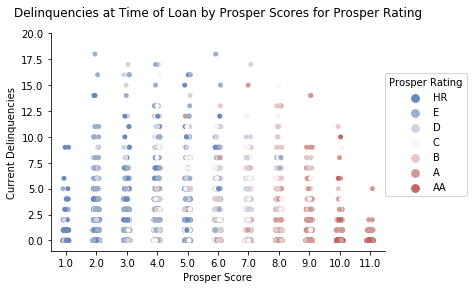

In [54]:
sb.stripplot(x='ProsperScore', y='CurrentDelinquencies', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Delinquencies at Time of Loan by Prosper Scores for Prosper Rating', y=1.05)
plt.ylim(-1,20)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Current Delinquencies')
plt.xlabel('Prosper Score')
sb.despine(top=True);

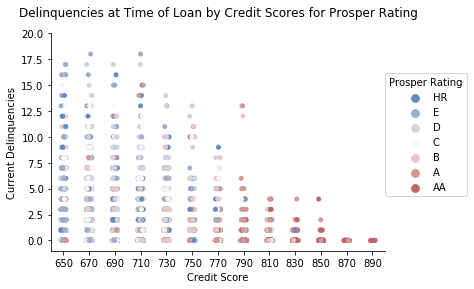

In [55]:
sb.stripplot(x='CreditScore', y='CurrentDelinquencies', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Delinquencies at Time of Loan by Credit Scores for Prosper Rating', y=1.05)
plt.ylim(-1,20)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Current Delinquencies')
plt.xlabel('Credit Score')
sb.despine(top=True);

The same observed in past plots happen for `CurrentDelinquencies`, in which it seems that this variable influences `CreditScore` more than it influences `ProsperScore`.

#### Influence of `IncomeVerifiable` and `IsBorrowerHomeowner`

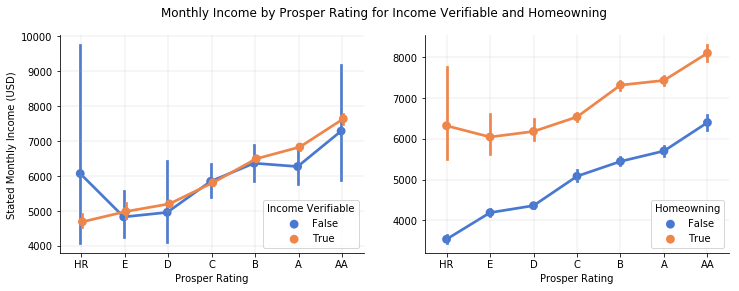

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

fig.suptitle('Monthly Income by Prosper Rating for Income Verifiable and Homeowning')

sb.pointplot(data=loans, y='StatedMonthlyIncome', x='ProsperRating', hue='IncomeVerifiable', palette='muted', dodge=True, ax=axs[0])
axs[0].grid(lw=0.2)
axs[0].set_ylabel('Stated Monthly Income (USD)')
axs[0].set_xlabel('Prosper Rating')
axs[0].legend(title='Income Verifiable')

sb.pointplot(x='ProsperRating', y='StatedMonthlyIncome', hue='IsBorrowerHomeowner', palette='muted', data=loans, ax=axs[1])
axs[1].grid(lw=0.2)
axs[1].set_ylabel('')
axs[1].set_xlabel('Prosper Rating')
axs[1].legend(title='Homeowning')

sb.despine(top=1)

Hard to say if `IncomeVerifiable` affects `ProsperRating`. We can see that the estimator for a `ProsperRating` of HR points to approximately USD 6,000, while the same value can be found at `ProsperRating` equal to C.

By looking at the other plot, owning a home doesn't seem to affect `ProsperRating`. Borrowers that receive an AA `ProsperRating` and do not own a home have, on average, `StatedMonthlyIncome` of USD 6,000, whereas borrowers that do own a home and have the same `StatedMontlyIncome` receive a lower rating. This indicates that other things might be influencing these ratings.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

For this part, I decided to plot the variables which I found to influence `ProsperRating` to see if I could find some hint of how this influence was related to the Scores. 

**The multivariate investigation did not give very good hints of how `ProsperRating` is formed, but it became clear of how these variables influence each one of the Scores. It seems that that `CreditScore` is more influenced by the variables we have available.**

Overall, we can see a slight interaction of the 3 variables plotted for most of the plots, in which is created sort of a diagonal dividing high `ProsperRating` to the extreme right of the plot and a slight increase of the concentration of points with high ratings as the points reach one of the extremes of the axis.

For some plots, however, there was really no relationship between the variables that would justify plotting multivariate plots.

### Were there any interesting or surprising interactions between features?

I did not really find what I was expecting. The secondary variables generally did not interact with each other and, as I had previously observed the interactions in bivariate plots, I was expecting to not find any surprising interaction in a multivariate plot that I could not have found using bivariate plots.